<a href="https://colab.research.google.com/github/teticio/aventuras-con-textos/blob/master/Clasificacion_de_texto_con_modelos_de_ultima_generacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img width="220px" src="https://frenomotor.com/files/2014/06/honda-civic-tuning.jpg" align="left" hspace="10px" vspace="0px"></p>

# Fine-tunear un modelo pre-entrenado para clasificar texto

## Comparamos Word2Vec, GloVe, ELMo, BERT y XLNet

Sobre todo si partimos de pocos datos (o bien poca capacidad de cómputo), tunear las últimas capas de un modelo que ha sido entrenado con un cuerpo de texto muy grande puede dar resultados impresionantes en poco tiempo.

<p><img width="220px" src="https://frenomotor.com/files/2014/06/honda-civic-tuning.jpg" align="left" hspace="10px" vspace="0px"></p>

# Fine-tuning a pre-trained model to classify text

## We compare Word2Vec, GloVe, ELMo, BERT and XLNet

Especially if we start with little data (or little computing capacity), tuning the last layers of a model that has been trained with a very large body of text can give impressive results in a short time.


# Importar las librerías

# Import libraries

In [ ]:
# instalar BERT
import sys

!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo
if not 'bert_repo' in sys.path:
    sys.path += ['bert_repo']

# import python modules defined by BERT
import tokenization

In [2]:
import os
import re
import json
import scipy
import shutil
import random
import pandas as pd
import numpy as np
import seaborn as sn
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import gensim.downloader as api
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
import keras.layers as layers
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, LSTM, Dropout
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
from keras.layers.embeddings import Embedding
from keras.engine import Layer
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['TFHUB_CACHE_DIR'] = './tfhub'
checkpoint_dir = 'checkpoints'  #@param {type : "string"}
limite_de_palabras_en_la_secuencia = 512  #@param {type : "number"}

Using TensorFlow backend.


In [3]:
sess = tf.Session()
K.set_session(sess)

# Conectar con Google Drive

# Connect with Google Drive

In [4]:
try:  # estamos en Google Colab?
    from google.colab import drive
    drive.mount('/content/drive')
    checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/checkpoints'
except:
    pass

### Crear directorio para los checkpoints (si no exista ya)

### Create directory for checkpoints (if it does not already exist)

In [5]:
try:
    os.makedirs(checkpoint_dir)
except FileExistsError:
    pass

# Descargar los datos

# Download the data

In [6]:
# de https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(
                re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)


def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)


def download_and_load_datasets(force_download=False):
    dataset = tf.keras.utils.get_file(
        "aclImdb.tar.gz",
        origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
        extract=True)
    train_df = load_dataset(
        os.path.join(os.path.dirname(dataset), "aclImdb", "train"))
    test_df = load_dataset(
        os.path.join(os.path.dirname(dataset), "aclImdb", "test"))
    return train_df, test_df


tf.logging.set_verbosity(tf.logging.ERROR)
train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,This is one the few movies I can watch over an...,8,1
1,"""Hey everybody! I've got an idea, we found thi...",2,0
2,OK this movie had a terrible premise. Be serio...,2,0
3,I love the series! Many of the stereotypes por...,10,1
4,I've been going through the AFI's list of the ...,1,0


### Definir unas funciones para visualizar los resultados

### Define functions to visualize the results

In [0]:
def plot_cosine_proximities(vectors, labels, title=None):
    cosine_proximities = np.array([[
        np.dot(vec_i, vec_j) / np.linalg.norm(vec_i) / np.linalg.norm(vec_j)
        for vec_i in vectors
    ] for vec_j in vectors])
    df_cm = pd.DataFrame(cosine_proximities, index=labels, columns=labels)
    fig = plt.figure(figsize=(10, 7))
    fig.suptitle(title, fontsize=24)
    sn.heatmap(df_cm, annot=True)


def plot_tsne(embedding_matrix, index_to_word, num_words=None, title='t-SNE'):
    matrix = embedding_matrix
    if num_words is not None:
        matrix = matrix[:num_words, :]
    labels = [index_to_word.get(_, "<UNK>") for _ in range(matrix.shape[0])]

    # defining the chart
    output_notebook()
    fig = bp.figure(plot_width=700,
                    plot_height=600,
                    title=title,
                    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                    x_axis_type=None,
                    y_axis_type=None,
                    min_border=1)

    # dimensionality reduction. converting the vectors to 2d vectors
    from sklearn.manifold import TSNE
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0)
    tsne_w2v = tsne_model.fit_transform(matrix)

    # putting everything in a dataframe
    tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
    tsne_df['words'] = labels

    # plotting. the corresponding word appears when you hover on the data point.
    fig.scatter(x='x', y='y', source=tsne_df)
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips = {"": "@words"}
    show(fig)

<p><img width="90px" src="https://cdn11.bigcommerce.com/s-kjvm95bh8i/images/stencil/500x659/products/41169/64495/sesame-street-elmo-gloves-3__42751.1512177126.jpg?c=2&imbypass=on" align="left" hspace="10px" vspace="0px"></p>

# GloVe / Word2Vec Embeddings

<p><img width="90px" src="https://cdn11.bigcommerce.com/s-kjvm95bh8i/images/stencil/500x659/products/41169/64495/sesame-street-elmo-gloves-3__42751.1512177126.jpg?c=2&imbypass=on" align="left" hspace="10px" vspace="0px"></p>

# GloVe / Word2Vec Embeddings

### Descargar los datos (otra vez) y tokenizar

### Download the data (again) and tokenize

In [ ]:
# * = un apaño porque actualmente no funciona
np_load_old = np.load  # *
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)  # *
(X_train, y_train), (X_test, y_test) = imdb.load_data()
np.load = np_load_old  # *
X_train = sequence.pad_sequences(X_train,
                                 maxlen=limite_de_palabras_en_la_secuencia)
X_test = sequence.pad_sequences(X_test,
                                maxlen=limite_de_palabras_en_la_secuencia)

### Descargar un embedding pre-entrenado

### Download a pre-trained embedding

In [0]:
embedding = "glove-twitter-200"  #@param ["glove-twitter-25", "glove-twitter-50", "glove-twitter-100", "glove-twitter-200", "glove-wiki-gigaword-50", "glove-wiki-gigaword-100", "glove-wiki-gigaword-200", "word2vec-google-news-300"]
embedding_model = api.load(embedding)  # 25, 50, 100, 200

### Crear una matriz de embedding con los índices que hemos adoptado

### Create an embedding matrix with the indexes we have adopted

In [0]:
# by convention, use 2 as OOV word
# reserve 'index_from' (=3 by default) characters:
# 0 (padding), 1 (start), 2 (OOV)
index_from = 3
oov = 0
word_index = imdb.get_word_index()
embedding_matrix = np.zeros(
    (len(word_index) + index_from + 1, embedding_model.vectors.shape[1]))
for word in word_index:
    word_ = re.sub(r'([^\s\w]|_)+', ' ', word)
    if word_ in embedding_model.vocab:
        embedding_matrix[word_index[word] +
                         index_from] = embedding_model.vectors[
                             embedding_model.vocab[word_].index]
    else:
        oov = oov + 1
print(f'OOV {oov}/{len(word_index)}')

OOV 35785/88584


### Construir el modelo

### Build the model

In [0]:
usar_embedding_preentrenado = True  #@param {type : "boolean"}
model = Sequential()
if usar_embedding_preentrenado:
    embedding_layer = Embedding(len(word_index) + index_from + 1,
                                embedding_model.vectors.shape[1],
                                input_length=X_train.shape[1],
                                weights=[embedding_matrix],
                                trainable=False)
else:
    embedding_layer = Embedding(len(word_index) + index_from + 1,
                                embedding_model.vectors.shape[1],
                                input_length=X_train.shape[1],
                                trainable=True)
model.add(embedding_layer)
model.add(Conv1D(256, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(256, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(256, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 512, 200)          17717600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 508, 256)          256256    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 101, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 97, 256)           327936    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 15, 256)           327936    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
__________

### Entrenar el modelo con un subconjunto de datos muy limitado

### Train the model with a very limited subset of data

In [0]:
weights = model.get_weights()
numero_de_muestras = 1000  #@param {type : 'number'}
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
]
model.fit(
    X_train[:numero_de_muestras],
    y_train[:numero_de_muestras],
    validation_data=(X_test[:numero_de_muestras], y_test[:numero_de_muestras]),
    epochs=20,
    batch_size=512  #@param {type : "number"}
    #@markdown La memoría utilizada por el GPU depende del tamaño del batch y el número de palabras en  las sequencias
    ,
    callbacks=callbacks)
model.set_weights(weights)  # resetear el modelo

Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.1890 - acc: 0.5460 - val_loss: 0.7173 - val_acc: 0.4740
Epoch 2/20
1000/1000 [==============================] - 1s 651us/step - loss: 0.7562 - acc: 0.5000 - val_loss: 0.7162 - val_acc: 0.5260
Epoch 3/20
1000/1000 [==============================] - 1s 652us/step - loss: 0.7059 - acc: 0.5160 - val_loss: 0.7096 - val_acc: 0.4760
Epoch 4/20
1000/1000 [==============================] - 1s 654us/step - loss: 0.7012 - acc: 0.4970 - val_loss: 0.6945 - val_acc: 0.4720
Epoch 5/20
1000/1000 [==============================] - 1s 654us/step - loss: 0.6984 - acc: 0.4590 - val_loss: 0.6920 - val_acc: 0.5260
Epoch 6/20
1000/1000 [==============================] - 1s 652us/step - loss: 0.6921 - acc: 0.5070 - val_loss: 0.6899 - val_acc: 0.5310
Epoch 7/20
1000/1000 [==============================] - 1s 654us/step - loss: 0.6877 - acc: 0.5960 - val_loss: 0.6943 - val_acc: 0.4760
Ep

### Entrenar con todos los datos de IMDB (fine-tuning)

### Train with all IMDB data (fine-tuning)

In [0]:
#model.load_weights(checkpoint_dir + '/Word2VecModel.h5')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min'),
    ModelCheckpoint(checkpoint_dir + '/Word2VecModel.h5',
                    save_best_only=True,
                    monitor='val_loss',
                    mode='min')
]
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=512  #@param {type : "number"}
    #@markdown La memoría utilizada por el GPU depende del tamaño del batch y el número de palabras en  las sequencias
    ,
    callbacks=callbacks)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 6s 223us/step - loss: 0.7135 - acc: 0.5545 - val_loss: 0.6066 - val_acc: 0.6726
Epoch 2/20
25000/25000 [==============================] - 3s 136us/step - loss: 0.4682 - acc: 0.7774 - val_loss: 0.3935 - val_acc: 0.8256
Epoch 3/20
25000/25000 [==============================] - 3s 136us/step - loss: 0.3664 - acc: 0.8385 - val_loss: 0.3877 - val_acc: 0.8237
Epoch 4/20
25000/25000 [==============================] - 3s 136us/step - loss: 0.3115 - acc: 0.8670 - val_loss: 0.3273 - val_acc: 0.8569
Epoch 5/20
25000/25000 [==============================] - 3s 137us/step - loss: 0.2534 - acc: 0.8969 - val_loss: 0.3178 - val_acc: 0.8656
Epoch 6/20
25000/25000 [==============================] - 3s 137us/step - loss: 0.2202 - acc: 0.9122 - val_loss: 0.3487 - val_acc: 0.8563
Epoch 7/20
25000/25000 [==============================] - 3s 137us/step - loss: 0.1258 - acc: 0.9557 - val_loss: 0.3516 - 

### Validar un modelo que ya hemos entrenado

### Validate a model that we have already trained

In [0]:
model.load_weights(checkpoint_dir + '/Word2VecModel.h5')
threshold = 0.5  #@param {type : "number", min : 0, max : 1}
test_pred = model.predict(X_test)
matrix = confusion_matrix(y_test, test_pred >= threshold)

In [0]:
print(f'val_acc {100 * np.trace(matrix)/np.sum(matrix):.2f}%')
print('Confusion matrix')
print(matrix)

val_acc 86.56%
Confusion matrix
[[11171  1329]
 [ 2032 10468]]


In [0]:
false_negatives = [
    _ for _ in range(len(X_test)) if y_test[_] and test_pred[_] < threshold
]
false_positives = [
    _ for _ in range(len(X_test))
    if not y_test[_] and test_pred[_] >= threshold
]

In [0]:
index_to_word = {}
for word in word_index:
    index_to_word[word_index[word]] = word
print('False negatives')
for sample in np.random.choice(false_negatives, 10, replace=False):
    text = " ".join([
        index_to_word[_ - index_from] for _ in X_test[sample] if _ > index_from
    ])
    print(f'[{float(test_pred[sample]):.2f}] {text}')
print()
print('False positives')
for sample in np.random.choice(false_positives, 10, replace=False):
    text = " ".join([
        index_to_word[_ - index_from] for _ in X_test[sample] if _ > index_from
    ])
    print(f'[{float(test_pred[sample]):.2f}] {text}')

False negatives
[0.11] spoilers br br as you may know i have been commenting on a lot of silent short films in the past months now i have no idea why i am commenting on steamboat willie i guess i was just desperate to comment on anything so i watched this and now i am commenting on it this or course is one of the very first cartoons and i believe it is not the first cartoon with sound br br here is the plot mickey mouse is driving a steamboat when pete throws him off and he drives it when they stop for cargo minnie mouse tried to get on but failed miserably mickey gets her up by a crane then a goat eats her sheet of paper with turkey in the straw on it they use the goat to make the song when i say that i mean that they used the goat as a victrola mickey plays the animals on the steamboat for instruments to the song then an angry pete throws mickey in a potato room and mickey is forced to peel potatoes for the rest of the day br br overall this is yet another groundbreaking silent short

### Visualizar el embedding con t-SNE

### Display the embedding with t-SNE

In [0]:
numero_de_palabras_mostrar = 10000  #@param {type : "number"}
embedding_matrix = embedding_layer.get_weights()[0]
index_to_word = {}
for word in word_index:
    index_to_word[word_index[word] + index_from] = word
plot_tsne(embedding_matrix, index_to_word, numero_de_palabras_mostrar)

Loading BokehJS ...

### Analogías: "un hombre es a una mujer como un rey es a ..."

### Analogies: "A man is to a woman like a king is to a ..."

In [0]:
analogies = [
    ('man', 'woman', 'king'),
    ('boy', 'girl', 'man'),
    ('water', 'ice', 'liquid'),
    ('bad', 'good', 'sad'),
    ('doctor', 'hospital', 'teacher'),
    ('italy', 'pizza', 'japan'),
    ('he', 'she', 'actor'),
    ('grass', 'green', 'sky'),
    ('madrid', 'spain', 'paris'),
    ('cat', 'small', 'lion'),
    ('10', 'ten', '30'),
]
for analogy in analogies:
    most_similar = embedding_model.most_similar(
        positive=[embedding_matrix[word_index[analogy[1]]+index_from], \
                  embedding_matrix[word_index[analogy[2]]+index_from]], \
        negative=[embedding_matrix[word_index[analogy[0]]+index_from]])
    for word in most_similar:
        if word[0] not in analogy:
            break
    print(f'{analogy[0]} is to {analogy[1]} as {analogy[2]} is to {word[0]}')

man is to woman as king is to queen
boy is to girl as man is to woman
water is to ice as liquid is to cream
bad is to good as sad is to great
doctor is to hospital as teacher is to class
italy is to pizza as japan is to sushi
he is to she as actor is to actress
grass is to green as sky is to blue
madrid is to spain as paris is to france
cat is to small as lion is to large
10 is to ten as 30 is to five


<p><img width="90px" src="https://cdn.sesamestreet.org/sites/default/files/1497545952/ElmoABCJump.gif" align="left" hspace="10px" vspace="0px"></p>

# ELMo - Embeddings from Language Models

![](http://www.realworldnlpbook.com/blog/images/elmo.png)
http://www.realworldnlpbook.com/blog/improving-sentiment-analyzer-using-elmo.html

[ELMo](https://arxiv.org/abs/1802.05365) es un *embedding* que se puede usar como una capa en una red neuronal para clasificar textos. El vector que asigna a una palabra depende no sólo de la palabra en sí, sino también de su contexto. Su uso es muy apropiado para casos en los cuales hay suficientes datos para entrenar un clasificador, pero no los suficientes para aprender de cero del contexto de las palabras. Tiene la ventaja de poder asignar vectores a cualquier palabra sin limitaciones de vocabulario (las mal deletreadas incluidas).

*   El input de la primera capa son vectores de palabras que resultan de un embedding de caracteres
*   Cada capa tiene dos LSTM independientes (ligeramente diferente al Bidirectional LSTM)
*   Ha sido preentrenado con el cuerpo de "Un Billón  de Palabras" (en inglés)
*   El embedding "ELMo" es la media de las tres capas ponderada por unos parámetros que son entrenables
*   El output es un embedding de toda la frase o por *token*, según la configuración inicial
*   Sólo hay un *encoder* (no hay *decoder*)

<p><img width="90px" src="https://cdn.sesamestreet.org/sites/default/files/1497545952/ElmoABCJump.gif" align="left" hspace="10px" vspace="0px"></p>

# ELMo - Embeddings from Language Models

![](http://www.realworldnlpbook.com/blog/images/elmo.png)
http://www.realworldnlpbook.com/blog/improving-sentiment-analyzer-using-elmo.html

[ELMo](https://arxiv.org/abs/1802.05365) is an *embedding* that can be used as a layer in a neural network to classify texts. The vector that you assign to a word depends not only on the word itself, but also on its context. Its use is very appropriate for cases in which there is enough data to train a classifier, but not enough to learn from scratch the context of the words. It has the advantage of being able to assign vectors to any word without vocabulary limitations (the misspelled ones included).

*   The input of the first layer are vectors of words that result from a character level embedding
*   Each layer has two independent LSTMs (slightly different from Bidirectional LSTM)
*   It has been pre-trained with the "A Billion of Words" corpus
*   The "ELMo" embedding is the average of the three layers, weighted by trainable parameters
*   The output is an embedding of the entire sentence or of each token, depending on the initial configuration
*   There is only a encoder (there is no decoder)

### Veamos cómo el embedding de una palabra depende del contexto

### Let's see how the embedding of a word depends on the context

In [ ]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
print(elmo.get_output_info_dict())
tokens_input = [
    ["stick", "", "", "", "", ""],
    ["let's", "stick", "to", "the", "plan", ""],
    ["hit", "me", "with", "your", "rhythm", "stick"],
    ["this", "is", "a", "sticky", "situation", ""],
    ["this", "is", "a", "stick", "", ""],
    ["this", "is", "not", "a", "stick", ""],
    ["this", "is", "a", "stick", "up", ""],
]
tokens_length = [len(_) - _.count("") for _ in tokens_input]
elmo_layers = ["word_emb", "lstm_outputs1", "lstm_outputs2", "elmo"]
embeddings = elmo(
    inputs={
        "tokens": tokens_input,
        "sequence_len": tokens_length
    },
    signature="tokens",
    as_dict=True)  # "elmo", "lstm_outputs1", "lstm_outputs2", "word_emb"
result = {}
sess.run(tf.global_variables_initializer())
for elmo_layer in elmo_layers:
    result[elmo_layer] = sess.run(embeddings[elmo_layer])

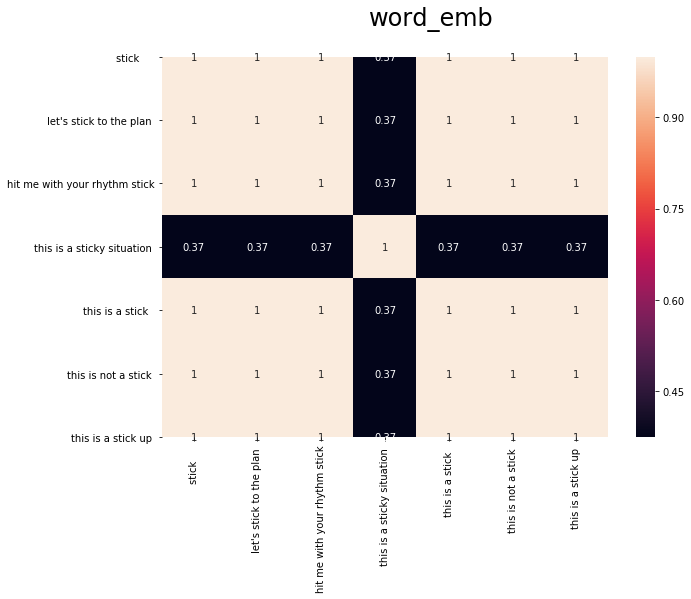

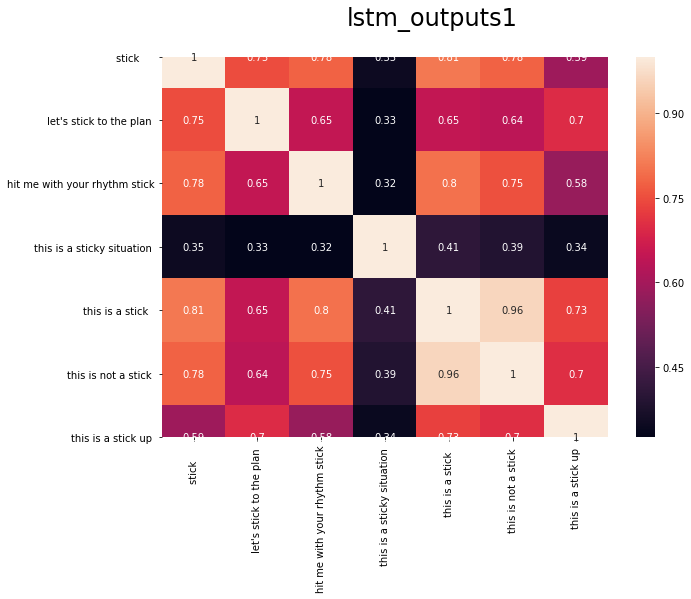

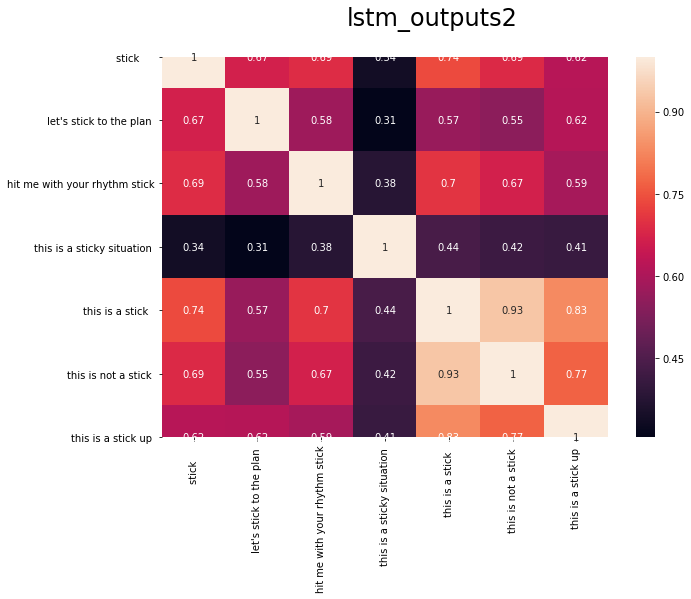

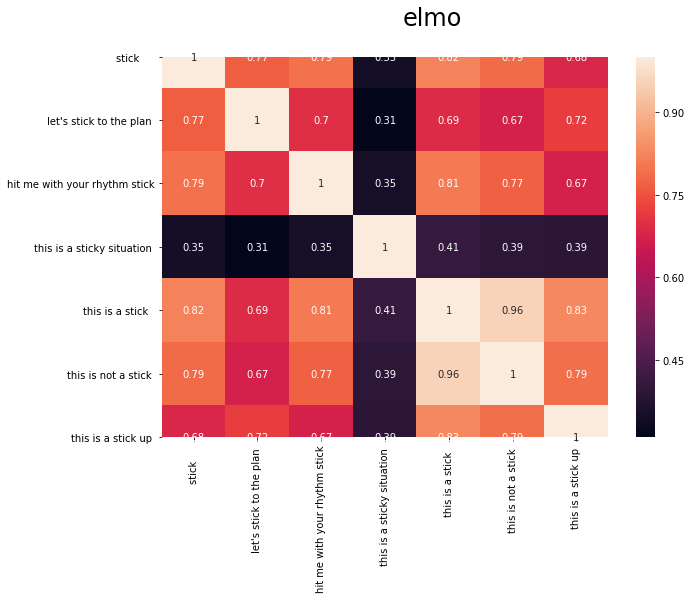

In [0]:
for elmo_layer in elmo_layers:
    sticks = [
        result[elmo_layer][i][j] for i, sentence in enumerate(tokens_input)
        for j, word in enumerate(sentence) if word[:len("stick")] == "stick"
    ]
    plot_cosine_proximities(
        sticks,
        [" ".join([word for word in sentence])
         for sentence in tokens_input], elmo_layer)

### Visualizar los embeddings para la misma palabra en frases distintras con ELMo

### Display embeddings for the same word in different phrases with ELMo

In [0]:
ejemplo = 'stick'  #@param {type : 'string'}
correspondencia_exacta = True  #@param {type : 'boolean'}
example_sentences = []
example_indices = []
sentences = []
for text in test_df['sentence'].tolist():
    sentences.extend(text.replace('!', '.').split('. '))
for sentence in sentences:
    words = sentence.split()
    for i, word in enumerate(words):
        if not correspondencia_exacta and ejemplo in word \
                or correspondencia_exacta and ejemplo == word:
            example_sentences.append((" ").join(words))
            example_indices.append(i)
            break
example_sentences = np.array(example_sentences, dtype=object)

In [0]:
# calcular los vectores correspondentes
batch_size = 32
result = {}
for batch in tqdm_notebook(range(len(example_sentences) // batch_size + 1)):
    embeddings = elmo(
        inputs=example_sentences[batch * batch_size:batch * batch_size +
                                 batch_size],
        signature="default",
        as_dict=True)  # "elmo", "lstm_outputs1", "lstm_outputs2", "word_emb"
    sess.run(tf.global_variables_initializer())
    for elmo_layer in elmo_layers:
        matrix = sess.run(embeddings[elmo_layer])
        for i in range(matrix.shape[0]):
            example_index = example_indices[batch * batch_size + i]
            vector = np.transpose(
                np.expand_dims(matrix[i, example_index], axis=1))
            if elmo_layer in result:
                result[elmo_layer] = np.concatenate(
                    (result[elmo_layer], vector), axis=0)
            else:
                result[elmo_layer] = vector

In [0]:
# calcular los vectores correspondentes
batch_size = 32
result = {}
for batch in tqdm_notebook(range(len(example_sentences) // batch_size + 1)):
    embeddings = elmo(
        inputs=example_sentences[batch * batch_size:batch * batch_size +
                                 batch_size],
        signature="default",
        as_dict=True)  # "elmo", "lstm_outputs1", "lstm_outputs2", "word_emb"
    sess.run(tf.global_variables_initializer())
    for elmo_layer in elmo_layers:
        matrix = sess.run(embeddings[elmo_layer])
        for i in range(matrix.shape[0]):
            example_index = example_indices[batch * batch_size + i]
            vector = np.transpose(
                np.expand_dims(matrix[i, example_index], axis=1))
            if elmo_layer in result:
                result[elmo_layer] = np.concatenate(
                    (result[elmo_layer], vector), axis=0)
            else:
                result[elmo_layer] = vector

In [0]:
# sacar un gráfico de t-SNE
elmo_layer = 'elmo'  #@param ["elmo", "lstm_outputs1", "lstm_outputs2", "word_emb"]
index_to_word = {}
for i, example_sentence in enumerate(example_sentences):
    index_to_word[i] = example_sentence
plot_tsne(embedding_matrix=result[elmo_layer],
          index_to_word=index_to_word,
          title=elmo_layer + ' t-SNE')

Loading BokehJS ...

### Definir una capa custom de Keras para ELMo

### Define a custom Keras layer for ELMo

In [0]:
class ElmoEmbeddingLayer(Layer):
    def __init__(
            self,
            elmo_layer='elmo',  # capa de embedding (o 'default' para el embedding de la frase)
            max_len=512,  # máximo número de tokens en las secuencias
            **kwargs):
        assert elmo_layer in [
            'elmo', 'lstm_outputs1', 'lstm_outputs2', 'word_emb', 'default'
        ]
        self.elmo_layer = elmo_layer
        self.max_len = max_len
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2',
                               trainable=self.trainable,
                               name="{}_module".format(self.name))
        if self.trainable:
            # los cuatro parámetros que determinan la capa 'elmo'
            self.trainable_weights += K.tf.trainable_variables(
                scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                           as_dict=True,
                           signature='default')[self.elmo_layer]
        if self.elmo_layer != 'default':
            # hacer que las secuencias tengan el mismo tamaño
            result = K.concatenate(
                (K.zeros((K.cast(K.shape(result)[0], dtype='int32'),
                          K.constant(self.max_len, dtype='int32')-K.cast(K.shape(result)[1], dtype='int32'),
                          K.cast(K.shape(result)[2], dtype='int32'))), \
                 result),
                 axis=1)
        return result

    def compute_output_shape(self, input_shape):
        if self.elmo_layer == 'default':
            # embedding de la frase
            return (input_shape[0], self.elmo.get_output_info_dict()
                    [elmo_layer].get_shape()[2].value)
        else:
            # embedding de las palabras
            return (input_shape[0], self.max_len,
                    self.elmo.get_output_info_dict()[elmo_layer].get_shape()
                    [2].value)

### Función para construir el modelo

### Function to build the model

In [0]:
def build_elmo_word_model(trainable=True, elmo_layer='elmo', max_len=512):
    input_text = Input(shape=(1, ), dtype="string")
    embedding = ElmoEmbeddingLayer(elmo_layer=elmo_layer,
                                   trainable=trainable,
                                   max_len=max_len)(input_text)
    conv = Conv1D(256, 5, activation='relu')(embedding)
    conv = MaxPooling1D(5)(conv)
    conv = Conv1D(256, 5, activation='relu')(conv)
    conv = MaxPooling1D(5)(conv)
    conv = Conv1D(256, 5, activation='relu')(conv)
    conv = MaxPooling1D(15)(conv)  # global max pooling
    flatten = Flatten()(conv)
    dense = Dense(256, activation='relu')(flatten)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model


def build_elmo_sentence_model(trainable=True):
    input_text = Input(shape=(1, ), dtype="string")
    embedding = ElmoEmbeddingLayer(elmo_layer='default',
                                   trainable=trainable)(input_text)
    dense = Dense(256, activation='relu')(embedding)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model

### Crear los conjuntos de datos

### Create the data sets

In [0]:
train_text = train_df['sentence'].tolist()
train_text = [
    ' '.join(t.split()[0:limite_de_palabras_en_la_secuencia])
    for t in train_text
]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_df['polarity'].tolist()

test_text = test_df['sentence'].tolist()
test_text = [
    ' '.join(t.split()[0:limite_de_palabras_en_la_secuencia])
    for t in test_text
]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = test_df['polarity'].tolist()

### Construir el modelo

### Build the model

In [0]:
entrenable = True  #@param {type : 'boolean'}
embedding_por_palabra = True  #@param {type : 'boolean'}
elmo_layer = 'elmo'  #@param ["elmo", "lstm_outputs1", "lstm_outputs2", "word_emb"]
if embedding_por_palabra:
    checkpoint_filename = '/ElmoWordModel.h5'
    elmo_model = build_elmo_word_model(
        trainable=entrenable,
        elmo_layer='elmo',
        max_len=limite_de_palabras_en_la_secuencia)
else:
    checkpoint_filename = '/ElmoSentenceModel.h5'
    elmo_model = build_elmo_sentence_model(trainable=entrenable)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 512, 1024)         4         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 508, 256)          1310976   
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 101, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 97, 256)           327936    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 19, 256)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 15, 256)           327936    
__________

### Entrenar el modelo con un subconjunto de datos muy limitado

### Train the model with a very limited subset of data

In [0]:
weights = elmo_model.get_weights()
numero_de_muestras = 1000  #@param {type : 'number'}
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
]
elmo_model.fit(
    train_text[:numero_de_muestras],
    train_label[:numero_de_muestras],
    validation_data=(test_text[:numero_de_muestras],
                     test_label[:numero_de_muestras]),
    epochs=20,
    batch_size=32  #@param {type : "number"}
    #@markdown La memoría utilizada por el GPU depende del tamaño del batch y el número de palabras en las sequencias
    ,
    callbacks=callbacks)
elmo_model.set_weights(weights)  # resetear el modelo

Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 144s 144ms/step - loss: 0.7430 - acc: 0.5560 - val_loss: 0.5923 - val_acc: 0.6960
Epoch 2/20
1000/1000 [==============================] - 142s 142ms/step - loss: 0.5246 - acc: 0.7430 - val_loss: 0.5499 - val_acc: 0.7480
Epoch 3/20
1000/1000 [==============================] - 141s 141ms/step - loss: 0.3801 - acc: 0.8340 - val_loss: 0.4932 - val_acc: 0.7890
Epoch 4/20
1000/1000 [==============================] - 139s 139ms/step - loss: 0.2738 - acc: 0.8910 - val_loss: 0.4506 - val_acc: 0.8090
Epoch 5/20
1000/1000 [==============================] - 141s 141ms/step - loss: 0.2342 - acc: 0.9090 - val_loss: 0.5524 - val_acc: 0.7550
Epoch 6/20
1000/1000 [==============================] - 142s 142ms/step - loss: 0.1115 - acc: 0.9610 - val_loss: 0.6136 - val_acc: 0.8010
Epoch 7/20
1000/1000 [==============================] - 142s 142ms/step - loss: 0.0430 - acc: 0.9900 - val_loss: 0.6477 - va

### Entrenar con todos los datos de IMDB (fine-tuning)

### Train with all IMDB data (fine-tuning)

In [0]:
#elmo_model.load_weights(checkpoint_dir + checkpoint_filename)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min'),
    ModelCheckpoint(checkpoint_dir + checkpoint_filename,
                    save_best_only=True,
                    monitor='val_loss',
                    mode='min')
]
elmo_model.fit(
    train_text,
    train_label,
    validation_data=(test_text, test_label),
    epochs=20,
    batch_size=32  #@param {type : 'number'}
    #@markdown La memoría utilizada por el GPU depende del tamaño del batch y el número de palabras en las sequencias
    ,
    callbacks=callbacks)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 1714s 69ms/step - loss: 0.3597 - acc: 0.8385 - val_loss: 0.2789 - val_acc: 0.8890
Epoch 2/20
25000/25000 [==============================] - 1693s 68ms/step - loss: 0.2532 - acc: 0.8992 - val_loss: 0.2558 - val_acc: 0.8954
Epoch 3/20
25000/25000 [==============================] - 1693s 68ms/step - loss: 0.2017 - acc: 0.9221 - val_loss: 0.2484 - val_acc: 0.8992
Epoch 4/20
25000/25000 [==============================] - 1690s 68ms/step - loss: 0.1500 - acc: 0.9426 - val_loss: 0.2841 - val_acc: 0.8888
Epoch 5/20
25000/25000 [==============================] - 1691s 68ms/step - loss: 0.1015 - acc: 0.9622 - val_loss: 0.3288 - val_acc: 0.8963
Epoch 6/20
25000/25000 [==============================] - 1691s 68ms/step - loss: 0.0699 - acc: 0.9745 - val_loss: 0.3575 - val_acc: 0.8926


In [0]:
# ver output de la capa de embedding
test = np.expand_dims(np.array(['hi there fans']), axis=0)
K.function([elmo_model.input, K.learning_phase()],
           [elmo_model.layers[1].output])([test, 1.])

[array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [-0.2897265 ,  0.04342684, -0.13304959, ..., -0.3292536 ,
           0.10790168, -0.18136144],
         [ 0.19243096, -0.18765599, -0.05203546, ...,  0.49453145,
          -0.07940593, -0.21373391],
         [-0.17233269, -0.30347633,  0.09974478, ...,  0.4113018 ,
           0.14885364,  0.11624762]]], dtype=float32)]

In [0]:
# los pesos asignados a los embeddings después del entrenamiento
K.get_session().run(elmo_model.trainable_weights[0])

array([ 0.24009205,  0.55799705, -0.5203339 ], dtype=float32)

In [0]:
# el factor de escalado después del entrenamiento
K.get_session().run(elmo_model.trainable_weights[1])

0.88082606

### Validar un modelo que ya hemos entrenado

### Validate a model that we have already trained

In [0]:
numero_de_muestras = 25000  #@param {type : 'number'}
elmo_model.load_weights(checkpoint_dir + checkpoint_filename)
threshold = 0.5  #@param {type : "number", min : 0, max : 1}
test_pred = elmo_model.predict(test_text[:numero_de_muestras])
matrix = confusion_matrix(test_label[:numero_de_muestras],
                          test_pred >= threshold)

In [0]:
print(f'val_acc {100 * np.trace(matrix)/np.sum(matrix):.2f}%')
print('Confusion matrix')
print(matrix)

val_acc 90.01%
Confusion matrix
[[11055  1445]
 [ 1053 11447]]


In [0]:
false_negatives = [
    _ for _ in range(numero_de_muestras)
    if test_label[_] and test_pred[_] < threshold
]
false_positives = [
    _ for _ in range(numero_de_muestras)
    if not test_label[_] and test_pred[_] >= threshold
]

In [0]:
print('False negatives')
for sample in np.random.choice(false_negatives, 10, replace=False):
    print(f'[{float(test_pred[sample]):.2f}] {test_text[sample][0]}')
print()
print('False positives')
for sample in np.random.choice(false_positives, 10, replace=False):
    print(f'[{float(test_pred[sample]):.2f}] {test_text[sample][0]}')

False negatives
[0.40] The movie starts with a board meeting at a major advertising agency. Putney Swope is on the board for no other reason than the fact that he is black, and the agency needs a "token" on the board. Swope is ignoring the meeting, reading Jet magazine at the big table, and everybody is ignoring Swope... Suddenly, the CEO croaks on the spot. No time is wasted. A janitor is called to haul off the corpse, and the board immediately and unceremoniously tackles the business of electing a new CEO. And as the votes are tallied one by one, the tension is built up and then finally snapped in a hilariously ironic climax to the vote, that gives the viewer a delicious dish of logical implications to savor for the rest of the movie. If you've ever talked back to some stupid television commercial, you'll like seeing this movie. Too bad there don't seem to be any real Putney Swopes in the world.
[0.39] Before I saw this film I didn't really expect to much from it, although my friend 

<p><img width="90px" src="https://vignette.wikia.nocookie.net/puppet/images/9/9c/Bert2000%27s.jpg/revision/latest?cb=20101221030132" align="left" hspace="10px" vspace="0px"></p>

# BERT - Bidirectional Encoder Representations for Transformers

![](https://miro.medium.com/max/1174/0*m_kXt3uqZH9e7H4w.png)

https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270

[BERT](https://arxiv.org/abs/1810.04805) está basado en el Transformer que usa un mecanismo de "atención" para fijarse en los elementos más relevantes del input en lugar de depender de la capacidad de memoria de un RNN como el LSTM, por ejemplo. Con BERT, Google consiguió varios resultados del estado del arte (SOTA o *State Of The Art*) en tareas tan diversas como clasificar sentimiento, contestar preguntas sobre un texto y reconocer entidades.

Un modelo de lenguaje (LM o *Language Model*) asigna una probabilidad a una palabra condicionada en las palabras anteriores. GPT (el predecesor de GPT-2) es un LM basado en el Transformer, pero sólo puede recorrer el texto en una dirección para evitar "hacer trampas" (es decir, no debe ver la palabra objetiva de manera indirecta). Sin embargo, BERT usa el Transformer en ambas direcciones. Para ello, tiene que entrenarse de una forma innovadora.

BERT ha sido pre-entrenado con dos tareas:
*   "Masked Language Modelling". Adivinar 15% palabras de un texto que han sido enmascaradas aleatoriamente.
*   "Next Sentence Matching". Decidir si dos frases de un texto son consecutivas o no.

Tokeniza el texto con WordPiece que rompe cada palabra en partes comunes (por ejemplo "helping" -> "help" + "##ing"). De este modo, el tamaño del vocabulario es más reducido mientras sigue respetando la similaridad entre "help" y "helping".

Es muy bueno para clasificar, resumir (con extractos, no abstractos) y contestar preguntas (por ejemplo, un chatbot). Sin embargo, al no ser un modelo de lenguaje, no es muy efectivo para generar o traducir textos. Hay modelos disponibles pre-entrenados con textos en varios idiomas. Todavía no hay ninguno disponible sólo para español, aunque Google ha entrenado uno con más de 100 idiomas (incluyendo español).

<p><img width="90px" src="https://vignette.wikia.nocookie.net/puppet/images/9/9c/Bert2000%27s.jpg/revision/latest?cb=20101221030132" align="left" hspace="10px" vspace="0px"></p>

# BERT - Bidirectional Encoder Representations for Transformers

![](https://miro.medium.com/max/1174/0*m_kXt3uqZH9e7H4w.png)

https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270

[BERT](https://arxiv.org/abs/1810.04805) is based on the Transformer that uses a "attention" mechanism to look at the most relevant elements of the input instead of relying on the memory capacity of an RNN like the LSTM, for example. With BERT, Google achieved several State Of The Art (SOTA) results in tasks as diverse as classifying sentiment, answering questions about a text and recognizing entities.

A language model (LM) assigns a probability to a conditioned word in the previous words. GPT (the predecessor of GPT-2) is an LM based on the Transformer, but you can only scroll the text in one direction to avoid "cheating" (that is, you should not see the objective word indirectly). However, BERT uses the Transformer in both directions. To do this, you have to train the model in an innovative way.

BERT has been pre-trained with two tasks:
*   "Masked Language Modeling". Guess 15% words from a text that have been randomly masked.
*   "Next Sentence Matching". Decide if two sentences in a text are consecutive or not.

Tokenize the text with WordPiece that breaks each word into common parts (for example "helping" -> "help" + "##ing"). In this way, the vocabulary size is smaller while still respecting the similarity between "help" and "helping".

It is very good to classify, summarize (with excerpts, not abstracts) and answer questions (for example, a chatbot). However, since it is not a language model, it is not very effective for generating or translating texts. There are pre-trained models available with texts in several languages. There are still none available for Spanish only, although Google has trained one with more than 100 languages (including Spanish).

### Descargar el modelo de BERT de Tensorflow Hub

### Download the BERT model from Tensorflow Hub

In [0]:
modelo_de_bert = 'bert_uncased_L-12_H-768_A-12/1'  #@param ["bert_uncased_L-12_H-768_A-12/1", "bert_cased_L-12_H-768_A-12/1", "bert_uncased_L-24_H-1024_A-16/1", "bert_cased_L-24_H-1024_A-16/1", "bert_multi_cased_L-12_H-768_A-12/1"]
bert = hub.Module('https://tfhub.dev/google/' + modelo_de_bert)

# instanciar el tokenizador
tokenization_info = bert(signature='tokenization_info', as_dict=True)
vocab_file, do_lower_case = sess.run([
    tokenization_info['vocab_file'],
    tokenization_info['do_lower_case'],
])
tokenizer = tokenization.FullTokenizer(vocab_file=vocab_file,
                                       do_lower_case=do_lower_case)

### Veamos un ejemplo de cómo usar BERT

### Let's see an example of how to use BERT

In [0]:
#tokenizer.tokenize("This here's an example of using the BERT tokenizer")
tokenizer.tokenize("Esto es un ejemplo de cómo usar el tokenizador de BERT")

['est',
 '##o',
 'es',
 'un',
 'e',
 '##je',
 '##mp',
 '##lo',
 'de',
 'como',
 'usa',
 '##r',
 'el',
 'token',
 '##iza',
 '##dor',
 'de',
 'bert']

In [0]:
# tokenizar e incluir los tokens [CLS] para "CLaSificar" (pooled_output) y [SEP] para separar las frases
tokens_input = ['[CLS]'
                ] + tokenizer.tokenize("let's stick to the plan") + ['[SEP]']
input_ids = np.expand_dims(np.array(
    tokenizer.convert_tokens_to_ids(tokens_input)),
                           axis=0)

# sin máscara (=1)
input_mask = np.ones(input_ids.shape)

# identificar las frases (segmentos): aquí sólo tenemos una
segment_ids = np.zeros(input_ids.shape)

# instanciar el modelo
bert_model = bert(dict(input_ids=input_ids,
                       input_mask=input_mask,
                       segment_ids=segment_ids),
                  signature="tokens",
                  as_dict=True)
sess.run(tf.global_variables_initializer())

# ponemos sequence_output para obtener los embeddings por palabra y pooled_output para obtener un embedding por frase
result = sess.run(bert_model['sequence_output'])

In [0]:
result

array([[[ 0.33146715, -0.12789908,  0.01895345, ..., -0.03692028,
          0.15176289,  0.42075726],
        [ 1.5566738 , -0.08537508, -0.82844895, ...,  0.82768774,
          0.6444146 ,  0.26434055],
        [ 1.1136669 ,  0.10625362,  0.42077667, ...,  0.5653054 ,
         -0.8229029 , -0.42940137],
        ...,
        [-0.03415444, -1.169551  , -0.15654448, ...,  0.24314609,
          0.05139359,  0.51759654],
        [ 0.4680526 , -0.36791974, -0.52337444, ...,  0.0658134 ,
         -0.27941763,  0.07135502],
        [ 1.004931  ,  0.03351047, -0.23235509, ...,  0.04084181,
         -0.5291848 , -0.4445516 ]]], dtype=float32)

In [0]:
result.shape

(1, 9, 768)

### Visualizar los embeddings para la misma palabra en frases distintras con BERT

### Display embeddings for the same word in separate phrases with BERT

In [0]:
# calcular los vectores correspondentes
batch_size = 32
result = None
example_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(ejemplo))[0]
for batch in tqdm_notebook(range(len(example_sentences) // batch_size + 1)):
    input_ids = []
    example_indices = []
    for example_sentence in example_sentences[batch *
                                              batch_size:batch * batch_size +
                                              batch_size]:
        tokens_input = ['[CLS]'
                        ] + tokenizer.tokenize(example_sentence) + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(
            tokens_input[:limite_de_palabras_en_la_secuencia])
        ids = ids + [0] * (limite_de_palabras_en_la_secuencia - len(ids))
        example_index = None
        for i, id in enumerate(ids):
            if id == example_id:
                example_index = i
                break
        input_ids.append(ids)
        example_indices.append(example_index)
    input_ids = np.array(input_ids)
    input_mask = np.ones(input_ids.shape)
    segment_ids = np.zeros(input_ids.shape)
    bert_model = bert(dict(input_ids=input_ids,
                           input_mask=input_mask,
                           segment_ids=segment_ids),
                      signature='tokens',
                      as_dict=True)
    sess.run(tf.global_variables_initializer())
    matrix = sess.run(bert_model['sequence_output'])
    for i in range(matrix.shape[0]):
        if example_indices[i] is None:
            continue
        vector = np.transpose(
            np.expand_dims(matrix[i, example_indices[i]], axis=1))
        if result is not None:
            result = np.concatenate((result, vector), axis=0)
        else:
            result = vector

In [0]:
# sacar un gráfico de t-SNE
index_to_word = {}
for i, example_sentence in enumerate(example_sentences):
    index_to_word[i] = example_sentence
plot_tsne(embedding_matrix=result,
          index_to_word=index_to_word,
          title='BERT t-SNE')

Loading BokehJS ...

### Definir una capa custom de Keras para BERT

### Define a custom Keras layer for BERT

In [0]:
class BertEmbeddingLayer(Layer):
    def __init__(
            self,
            output_key='sequence_output',  # 'sequence_output': embedding de las palabras, 'pooled_ouput': embedding de la frase
            n_fine_tune_layers=0,  # número de capas a entrenar (sin contar la de pooling)
            bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",  # modelo de BERT preentrenado
            max_len=512,  # número máximo de tokens en las secuencias
            **kwargs):
        assert output_key == 'sequence_output' or output_key == 'pooled_output'
        super(BertEmbeddingLayer, self).__init__(**kwargs)
        self.output_key = output_key
        self.n_fine_tune_layers = n_fine_tune_layers
        self.bert_path = bert_path
        self.max_len = max_len

    def build(self, input_shape):
        self.bert = hub.Module(self.bert_path,
                               trainable=self.trainable,
                               name="{}_module".format(self.name))
        if self.trainable:
            if self.output_key == 'pooled_output':
                # añadir las variables de la capa de pooling a las que vammos a entrenar
                self.trainable_weights += [
                    var for var in self.bert.variables if 'pooler/' in var.name
                ]
            # añadir las variables de las últimas n capas a las que vamos a entrenar
            top_layer = max([
                int(_[_.find('layer_'):][6:_[_.find('layer_'):].find('/')])
                for _ in
                [var.name for var in bert.variables if 'layer_' in var.name]
            ])
            self.trainable_weights += [
                var for var in self.bert.variables if any([
                    f'layer_{top_layer-i}/' in var.name
                    for i in range(self.n_fine_tune_layers)
                ])
            ]
            self.non_trainable_weights += [
                var for var in self.bert.variables
                if var not in self.trainable_weights
            ]
        super(BertEmbeddingLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype='int32') for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(input_ids=input_ids,
                           input_mask=input_mask,
                           segment_ids=segment_ids)
        result = self.bert(inputs=bert_inputs,
                           signature='tokens',
                           as_dict=True)[self.output_key]
        return result

    def compute_output_shape(self, input_shape):
        if self.output_key == 'pooled_output':
            # embedding de la frase
            return (input_shape[0], self.bert.get_output_info_dict('tokens')[
                self.output_key].get_shape()[1].value)
        else:
            # embedding de las palabras
            return (input_shape[0], self.max_len,
                    self.bert.get_output_info_dict('tokens')[
                        self.output_key].get_shape()[2].value)

### Función para construir el modelo

### Function to build the model

In [0]:
def build_bert_word_model(
        trainable=True,
        n_fine_tune_layers=10,
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        max_len=limite_de_palabras_en_la_secuencia):
    in_id = Input(shape=(max_len, ), name="input_ids")
    in_mask = Input(shape=(max_len, ), name="input_masks")
    in_segment = Input(shape=(max_len, ), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    embedding = BertEmbeddingLayer(trainable=trainable,
                                   output_key='sequence_output',
                                   n_fine_tune_layers=n_fine_tune_layers,
                                   bert_path=bert_path,
                                   max_len=max_len)(bert_inputs)
    conv = Conv1D(256, 5, activation='relu')(embedding)
    conv = MaxPooling1D(5)(conv)
    conv = Conv1D(256, 5, activation='relu')(conv)
    conv = MaxPooling1D(5)(conv)
    conv = Conv1D(256, 5, activation='relu')(conv)
    conv = MaxPooling1D(15)(conv)  # global max pooling
    flatten = Flatten()(conv)
    dense = Dense(256, activation='relu')(flatten)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model


def build_bert_sentence_model(
        trainable=True,
        n_fine_tune_layers=10,
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        max_len=limite_de_palabras_en_la_secuencia):
    in_id = Input(shape=(max_len, ), name="input_ids")
    in_mask = Input(shape=(max_len, ), name="input_masks")
    in_segment = Input(shape=(max_len, ), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    embedding = BertEmbeddingLayer(trainable=trainable,
                                   output_key='pooled_output',
                                   n_fine_tune_layers=n_fine_tune_layers,
                                   bert_path=bert_path,
                                   max_len=max_len)(bert_inputs)
    dense = Dense(256, activation='relu')(embedding)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model

### Tokenizar y crear los demás inputs (máscara, segmento y etiqueta) para BERT

### Tokenize and create the other inputs (mask, segment and label) for BERT

In [0]:
train_examples = train_df['sentence'].tolist()
train_examples = [['[CLS]'] + tokenizer.tokenize(t) + ['[SEP]']
                  for t in tqdm_notebook(train_examples, desc='tokenizing')]
train_examples = [
    tokenizer.convert_tokens_to_ids(t[:limite_de_palabras_en_la_secuencia])
    for t in train_examples
]
train_mask = [[1] * len(_) for _ in train_examples]
train_examples = sequence.pad_sequences(
    train_examples, maxlen=limite_de_palabras_en_la_secuencia, padding='post')
train_mask = sequence.pad_sequences(train_mask,
                                    maxlen=limite_de_palabras_en_la_secuencia,
                                    padding='post')
train_segment = np.zeros(train_examples.shape)
train_label = train_df['polarity'].tolist()

test_examples = test_df['sentence'].tolist()
test_examples = [['[CLS]'] + tokenizer.tokenize(t) + ['[SEP]']
                 for t in tqdm_notebook(test_examples, desc='tokenizing')]
test_examples = [
    tokenizer.convert_tokens_to_ids(t[:limite_de_palabras_en_la_secuencia])
    for t in test_examples
]
test_mask = [[1] * len(_) for _ in test_examples]
test_examples = sequence.pad_sequences(
    test_examples, maxlen=limite_de_palabras_en_la_secuencia, padding='post')
test_mask = sequence.pad_sequences(test_mask,
                                   maxlen=limite_de_palabras_en_la_secuencia,
                                   padding='post')
test_mask = np.ones(test_examples.shape)
test_segment = np.ones(test_examples.shape)
test_label = test_df['polarity'].tolist()

### Construir el modelo

### Build the model

In [0]:
entrenable = False  #@param {type : 'boolean'}
numero_de_capas_a_tunear = 0  #@param {type : 'slider', min : 0, max : 24}
embedding_por_palabra = True  #@param {type : 'boolean'}
if embedding_por_palabra:
    checkpoint_filename = '/BertWordModel.h5'
    bert_model = build_bert_word_model(
        trainable=entrenable,
        n_fine_tune_layers=numero_de_capas_a_tunear,
        bert_path='https://tfhub.dev/google/' + modelo_de_bert,
        max_len=limite_de_palabras_en_la_secuencia)
else:
    checkpoint_filename = '/BertSentenceModel.h5'
    bert_model = build_bert_sentence_model(
        trainable=entrenable,
        n_fine_tune_layers=numero_de_capas_a_tunear,
        bert_path='https://tfhub.dev/google/' + modelo_de_bert,
        max_len=limite_de_palabras_en_la_secuencia)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 512)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
bert_embedding_layer_1 (BertEmb ((None, 512), 512, 7 0           input_ids[0][0]                  
                                                                 input_masks[0][0]                
          

### Entrenar el modelo con un subconjunto de datos muy limitado

### Train the model with a very limited subset of data

In [0]:
weights = bert_model.get_weights()
numero_de_muestras = 1000  #@param {type : 'number'}
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
]
bert_model.fit(
    [
        train_examples[:numero_de_muestras], train_mask[:numero_de_muestras],
        train_segment[:numero_de_muestras]
    ],
    train_label[:numero_de_muestras],
    validation_data=([
        test_examples[:numero_de_muestras], test_mask[:numero_de_muestras],
        test_segment[:numero_de_muestras]
    ], test_label[:numero_de_muestras]),
    epochs=40,
    batch_size=32  #@param {type : "number"}
    #@markdown La memoría utilizada por el GPU depende del tamaño del batch y el número de palabras en las sequencias
    ,
    callbacks=callbacks)
bert_model.set_weights(weights)  # resetear el modelo

Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 166s 166ms/step - loss: 0.7576 - acc: 0.5390 - val_loss: 0.6924 - val_acc: 0.5170
Epoch 2/20
1000/1000 [==============================] - 159s 159ms/step - loss: 0.5061 - acc: 0.7640 - val_loss: 0.6331 - val_acc: 0.6500
Epoch 3/20
1000/1000 [==============================] - 159s 159ms/step - loss: 0.3394 - acc: 0.8510 - val_loss: 1.1477 - val_acc: 0.5770
Epoch 4/20
1000/1000 [==============================] - 159s 159ms/step - loss: 0.2408 - acc: 0.9030 - val_loss: 0.8085 - val_acc: 0.7000
Epoch 5/20
1000/1000 [==============================] - 159s 159ms/step - loss: 0.1835 - acc: 0.9260 - val_loss: 2.3546 - val_acc: 0.5350


### Entrenar con todos los datos de IMDB (fine-tuning)

### Train with all IMDB data (fine-tuning)

In [0]:
#bert_model.load_weights(checkpoint_dir + checkpoint_filename)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min'),
    ModelCheckpoint(checkpoint_dir + checkpoint_filename,
                    save_best_only=True,
                    monitor='val_loss',
                    mode='min')
]
bert_model.fit(
    [train_examples, train_mask, train_segment],
    train_label,
    validation_data=([test_examples, test_mask, test_segment], test_label),
    epochs=20,
    batch_size=32  #@param {type : "number"}
    #@markdown La memoría utilizada por el GPU depende del tamaño del batch y el número de palabras en las sequencias
    ,
    callbacks=callbacks)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 772s 31ms/step - loss: 0.3073 - acc: 0.8660 - val_loss: 0.5281 - val_acc: 0.7564
Epoch 2/20
25000/25000 [==============================] - 766s 31ms/step - loss: 0.2266 - acc: 0.9113 - val_loss: 0.4593 - val_acc: 0.7904
Epoch 3/20
25000/25000 [==============================] - 766s 31ms/step - loss: 0.1957 - acc: 0.9236 - val_loss: 0.2798 - val_acc: 0.8880
Epoch 4/20
25000/25000 [==============================] - 766s 31ms/step - loss: 0.1625 - acc: 0.9372 - val_loss: 0.6955 - val_acc: 0.7652
Epoch 5/20
25000/25000 [==============================] - 766s 31ms/step - loss: 0.1301 - acc: 0.9510 - val_loss: 0.5381 - val_acc: 0.8151
Epoch 6/20
25000/25000 [==============================] - 766s 31ms/step - loss: 0.0992 - acc: 0.9635 - val_loss: 0.5915 - val_acc: 0.8227


### Validar un modelo que ya hemos entrenado

### Validate a model that we have already trained

In [0]:
numero_de_muestras = 25000  #@param {type : 'number'}
bert_model.load_weights(checkpoint_dir + checkpoint_filename)
threshold = 0.5  #@param {type : "number", min : 0, max : 1}
test_pred = bert_model.predict([
    test_examples[:numero_de_muestras], test_mask[:numero_de_muestras],
    test_segment[:numero_de_muestras]
])
matrix = confusion_matrix(test_label[:numero_de_muestras],
                          test_pred >= threshold)

In [0]:
print(f'val_acc {100 * np.trace(matrix)/np.sum(matrix):.2f}%')
print('Confusion matrix')
print(matrix)

val_acc 88.99%
Confusion matrix
[[11678   822]
 [ 1930 10570]]


In [0]:
false_negatives = [
    _ for _ in range(numero_de_muestras)
    if test_label[_] and test_pred[_] < threshold
]
false_positives = [
    _ for _ in range(numero_de_muestras)
    if not test_label[_] and test_pred[_] >= threshold
]

In [0]:
print('False negatives')
for sample in np.random.choice(false_negatives, 10, replace=False):
    print(
        f'[{float(test_pred[sample]):.2f}] {test_df["sentence"].tolist()[sample]}'
    )
print()
print('False positives')
for sample in np.random.choice(false_positives, 10, replace=False):
    print(
        f'[{float(test_pred[sample]):.2f}] {test_df["sentence"].tolist()[sample]}'
    )

False negatives
[0.01] A very strange, disturbing but intriguing film. I don't think I ever needed to see what a human being can do with his butt, and I doubt if I'll ever want to see it again. That said, there is much to be amused by, like Divine's take on Jayne Mansfield's classic walk in "The Girl Can't Help It" and putting slabs of meat between her legs in a grocery store. A gritty feel very much like a Russ Meyer film. Generally poor acting, with the notable exception of Divine.
[0.27] Harrowing series about life in Oz--an experimental prison where they try to rehabilitate prisoners. There's gay sex, rape, torture, mutilation, killings, humiliation, tons of male nudity...all in your face and going full force.<br /><br />It also is easily one of the best written dramas ever put on TV and almost all the actors are just great. Since this was on cable there were no restrictions on what they could say or show. There's plenty of racist comments flying in here but it's for all races. In 

### La importancia de los hiperparámetros

### The importance of hyperparameters

In [7]:
#!pip install -q ktrain

preprocessing train...


preprocessing test...


Is Multi-Label? False
maxlen is 500
done.
simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
 6624/25000 [======>.......................] - ETA: 18:25 - loss: 0.6576 - acc: 0.6422

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


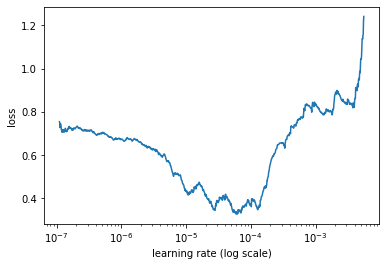

In [7]:
import ktrain
from ktrain import text as txt

# load data
(x_train, y_train), (x_test, y_test), preproc = txt.texts_from_folder('/home/teticio/.keras/datasets/aclImdb', maxlen=500, 
                                                                     preprocess_mode='bert',
                                                                     train_test_names=['train', 'test'],
                                                                     classes=['pos', 'neg'])

# load model
model = txt.text_classifier('bert', (x_train, y_train))

# wrap model and data in ktrain.Learner object
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=6)

# find good learning rate
learner.lr_find()             # briefly simulate training to find good learning rate
learner.lr_plot()             # visually identify best learning rate

In [8]:
# train using 1cycle learning rate schedule for 3 epochs
learner.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 1955s 78ms/step - loss: 0.2606 - acc: 0.8912 - val_loss: 0.2193 - val_acc: 0.9212
Epoch 2/3
25000/25000 [==============================] - 1973s 79ms/step - loss: 0.1597 - acc: 0.9432 - val_loss: 0.2012 - val_acc: 0.9256
Epoch 3/3
25000/25000 [==============================] - 1879s 75ms/step - loss: 0.0536 - acc: 0.9826 - val_loss: 0.1780 - val_acc: 0.9419


### Algunas conclusiones

El modelo de BERT pre-entrenado es muy efectivo con pocos datos de entrenamiento. Limitando los datos de IMDB a 1,000 muestras de entrenamiento y 1,000 muestras de validación, acertamos con 87% de los datos de validación con el modelo "pequeño" de BERT y los embeddings por palabra (frente a 81% con ELMo y 70% con GloVe). Al ser un modelo mucho más grande que ELMo (336 millones de parámeteros del modelo grande de BERT versus los 13,6 millones del modelo de ELMo*), necesitamos muchos más datoos de entrenamiento si queremos obtener un buen resultado entrenando las capas de BERT ("fine-tuning"). Según https://paperswithcode.com/sota/sentiment-analysis-on-imdb, BERT ha conseguido una nota de 95.8% aplicando técnicas de aumentación de datos.

\* Es posible descargar modelos de ELMo pre-entrenados más grandes aquí: https://allennlp.org/elmo, pero, aún así, en el mayor de los casos cuentan con "sólo" 93,6 millones de parámetros.

### Some conclusions

The pre-trained BERT model is very effective with little training data. By limiting IMDB data to 1,000 training samples and 1,000 validation samples, we are correct with 87% of the validation data with the "small" BERT model and the embeddings per word (compared to 81% with ELMo and 70% with GloVe ). Being a much larger model than ELMo (336 million parameters of the large BERT model versus 13.6 million of the ELMo model *), we need many more training data if we want to obtain a good result by training the layers of BERT ("fine-tuning"). According to https://paperswithcode.com/sota/sentiment-analysis-on-imdb, BERT has achieved a score of 95.8% applying data augmentation techniques.

\* It is possible to download larger pre-trained ELMo models here: https://allennlp.org/elmo, but even so, in most cases they have "only" 93.6 million parameters.

<p><img width="90px" src="https://cdn.vox-cdn.com/thumbor/JFmmLp25gpvP7kbRZU-PigUz-mA=/0x94:1494x1090/920x613/filters:focal(0x94:1494x1090):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/45686844/big_bird_half.0.0.jpg" align="left" hspace="10px" vspace="0px"></p>

# XLNet - Transformer-XL Network

![](https://miro.medium.com/max/904/0*jzfLbSYA-VH5P7rC.png)

https://medium.com/dair-ai/xlnet-outperforms-bert-on-several-nlp-tasks-9ec867bb563b

[XLNet](https://arxiv.org/abs/1906.08237) coge el testigo de BERT y consigue unos resultados del estado del arte.

BERT tiene una discrepancia entre la forma de pre-entrenarse y el *fine-tuning* porque los token [MASK] sólo aparecen en la primera fase y no en la segunda. Toma unas medidas para mitigar el efecto (aleatoriamente remplaza el [MASK] con otro token) pero no es óptimo. Además, BERT asume independencia entre los tokens que tiene que adivinar.

XLNet propone una solución innovador a estos problemas. No recorre el texto en ambas direcciones pero, para no perder la ventaja que aporta tener el contexto a cada lado de una palabra, considera todas las permutaciones de un bloque de palabras. Adicionalmente, mantiene dos "stream" de atención: una del contexto, en el cual puede aparecer el token que está prediciendo, y otra de la adivinanza en el cual no puede parecer el token objetivo. De esta manera, consigue la máxima información contextual sin "hacer trampas".

![](https://miro.medium.com/max/598/0*Cd9pc-cuqQF5k0Oc.png)

Las siglas "XL" vienen del XLTransformer, del cual ha tomado prestada la idea de encadenar Transformers que operan sobre bloques consecutivos de texto. El vector de embedding de salida de un Transformer sirve de entrada para el siguiente.

<p><img width="90px" src="https://cdn.vox-cdn.com/thumbor/JFmmLp25gpvP7kbRZU-PigUz-mA=/0x94:1494x1090/920x613/filters:focal(0x94:1494x1090):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/45686844/big_bird_half.0.0.jpg" align="left" hspace="10px" vspace="0px"></p>

# XLNet - Transformer-XL Network

![](https://miro.medium.com/max/904/0*jzfLbSYA-VH5P7rC.png)

https://medium.com/dair-ai/xlnet-outperforms-bert-on-several-nlp-tasks-9ec867bb563b

[XLNet](https://arxiv.org/abs/1906.08237) take the baton from BERT and obtains state of the art reults.

BERT has a discrepancy between the way of pre-training and fine-tuning because the [MASK] tokens only appear in the first phase and not in the second. Steps are taken to mitigate the effect (randomly replace the [MASK] with another token) but it is not optimal. In addition, BERT assumes independence among the tokens that it has to guess.

XLNet proposes an innovative solution to these problems. It does not go through the text in both directions but, in order not to lose the advantage of having context on each side of a word, it considers all the permutations of a block of words. Additionally, it maintains two "streams" of attention: a context stream, in which the token it is predicting may appear, and a query stream in which the objective token may not appear. In this way, it gets maximum contextual information without "cheating."

![](https://miro.medium.com/max/598/0*Cd9pc-cuqQF5k0Oc.png)

The acronym "XL" comes from the XLTransformer, which has borrowed the idea of chaining Transformers that operate on consecutive blocks of text. The output embedding vector of one Transformer serves as input for the next.

### Instalar el modelo, descargar los datos (otra vez) y los checkpoints

### Install the model, download the data (again) and checkpoints

In [ ]:
!pip install sentencepiece
!git clone https://github.com/zihangdai/xlnet.git
%cd xlnet
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar zxf aclImdb_v1.tar.gz
!wget https://storage.googleapis.com/xlnet/released_models/cased_L-24_H-1024_A-16.zip
!unzip cased_L-24_H-1024_A-16.zip
!rm aclImdb_v1.tar.gz
!rm cased_L-24_H-1024_A-16.zip

### Entrenar con los datos de IMDB (fine-tuning)





### Train with IMDB (fine-tuning) data

In [0]:
command = sys.executable + ' run_classifier.py \
  --use_tpu=False \
  --do_train=True \
  --do_eval=True \
  --eval_all_ckpt=False \
  --task_name=imdb \
  --data_dir=aclImdb \
  --output_dir=./proc_data/imdb \
  --model_dir="'+checkpoint_dir+'/xlnet" \
  --uncased=False \
  --spiece_model_file=./xlnet_cased_L-24_H-1024_A-16/spiece.model \
  --model_config_path=./xlnet_cased_L-24_H-1024_A-16/xlnet_config.json \
  --init_checkpoint=./xlnet_cased_L-24_H-1024_A-16/xlnet_model.ckpt \
  --max_seq_length=512 \
  --train_batch_size=1 \
  --eval_batch_size=1 \
  --num_hosts=1 \
  --num_core_per_host=1 \
  --learning_rate=2e-5 \
  --train_steps=4000 \
  --warmup_steps=500 \
  --save_steps=500 \
  --iterations=500 \
'
!{command}

### Validar un modelo que ya hemos entrenado



### Validate a model that we have already trained

In [0]:
!rm -rf proc_data/*
command = sys.executable + ' run_classifier.py \
  --use_tpu=False \
  --do_predict=True \
  --predict_dir="'+checkpoint_dir+'/xlnet" \
  --task_name=imdb \
  --data_dir=aclImdb \
  --output_dir=./proc_data/imdb \
  --model_dir="'+checkpoint_dir+'/xlnet" \
  --uncased=False \
  --spiece_model_file=./xlnet_cased_L-24_H-1024_A-16/spiece.model \
  --model_config_path=./xlnet_cased_L-24_H-1024_A-16/xlnet_config.json \
  --init_checkpoint="'+checkpoint_dir+'/xlnet/model.ckpt-4000" \
  --max_seq_length=512 \
  --eval_batch_size=1 \
  --predict_batch_size=1 \
'
!{command}

In [0]:
with open(checkpoint_dir + '/xlnet/imdb.logits.json', 'r') as f:
    results = json.load(f)
classifications = pd.read_csv(checkpoint_dir + '/xlnet/imdb.tsv', sep='\t')
false_pos = []
directory = 'aclImdb/test/neg'
num_neg = len(os.listdir(directory))
for i, filename in enumerate(os.listdir(directory)):
    if classifications['prediction'][i] == 'pos':
        with open(os.path.join(directory, filename), 'r') as file:
            text = " ".join(
                file.readline().split()[:limite_de_palabras_en_la_secuencia])
        false_pos.append(
            (text, np.exp(results[i][1]) / np.sum(np.exp(results[i]), axis=0)))
false_neg = []
directory = 'aclImdb/test/pos'
num_pos = len(os.listdir(directory))
for i, filename in enumerate(os.listdir(directory)):
    if classifications['prediction'][i + num_neg] == 'neg':
        with open(os.path.join(directory, filename), 'r') as file:
            text = " ".join(
                file.readline().split()[:limite_de_palabras_en_la_secuencia])
        false_neg.append((text, np.exp(results[i + num_neg][1]) /
                          np.sum(np.exp(results[i + num_neg]), axis=0)))

In [0]:
print(f'val_acc {1-(len(false_neg) + len(false_pos))/(num_neg + num_pos):.4f}')
matrix = np.array([[num_neg, len(false_pos)], [len(false_neg), num_pos]])
print('Confusion matrix')
print(matrix)

val_acc 0.9452
Confusion matrix
[[12500   811]
 [  559 12500]]


In [0]:
print('False negatives')
random_indices = np.random.choice(range(len(false_neg)), 10, replace=False)
for i in random_indices:
    print(f'[{float(false_neg[i][1]):.2f}] {false_neg[i][0]}')
print()
print('False positives')
random_indices = np.random.choice(range(len(false_pos)), 10, replace=False)
for i in random_indices:
    print(f'[{float(false_pos[i][1]):.2f}] {false_pos[i][0]}')

False negatives
[0.00] After traveling around the world, it dawned on me that Australia really lacks one thing that other countries have: history.<br /><br />Fortunately or unfortunately, Australia wasn't establish following a war, it has not had a civil war and most of its political history is rather..... boring! Nothing "big" happened to mark some sort of turning point in Australia's history.... until the dismissal of the Whitlam government by the Governor-general of Australia - John Kerr.<br /><br />For those who are Australian, you can skip this paragraph and move onto the next. This is for the benefit of curious non-Australians! Australia was colonised by the British. As time went on, it became apparent that Australia was capable of standing on its own two feet. Accordingly, the UK granted Australia permission to establish its own parliaments, laws, courts and so on. The law and politics of Australia would no longer be provided directly from the British; rather, Australia would be

# TODO:
only download data once

tidy up install of XLNet

update conclusions

ERNIE 2.0